In [ ]:
#hide
from inpaint_melanoma import *

# Inpaint melanoma skin lesions

> Inpaint melanoma skin lesions using deep image prior.

This file will become your README and also the index of your documentation.

## Install

`pip install your_project_name`

## How to use

Fill me in please! Don't forget code examples:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch import nn
from inpaint_melanoma.skip import *
from PIL import Image
# from utils.common_utils import *
# from models.skip import *

In [ ]:
filename = 'ISIC_0076742'
# if cloud
# from google.colab import drive
# drive.mount('/content/gdrive/')
# path_source = '/content/gdrive/My Drive/KCL/melanoma/size_512/'
# path_img_dest = '/content/gdrive/My Drive/KCL/melanoma/results_512/'
# if local
path_source = '/mnt/c/Users/octav/Documents/Datasets/melanoma/size_512/'
path_img_dest = '/mnt/c/Users/octav/Documents/Datasets/melanoma/results_size_512/'

In [ ]:
img = plt.imread(f'{path_source}{filename}.jpg')
mask_lesion = np.load(f'{path_source}mask_{filename}.npz')
mask_lesion = mask_lesion.f.arr_0
mask_inpain = ~mask_lesion
# reshape and normalize
img = channels_first_last(img,'first')
img = img/255.
mask_inpain = mask_inpain.astype('int')
print(f'img: {np.shape(img), np.shape(mask_inpain)}')

img: ((3, 512, 512), (512, 512))


## parameters

In [ ]:
# parameters
run_epochs = 51
channels_input = 32
channels_layers = [32, 64]
channels_skip = [0]*len(channels_layers)
channels_layers_str = [str(i) for i in channels_layers]
channels_skip_str = [str(i) for i in channels_skip]
layers_str ='_'.join(channels_layers_str)
skip_str ='_'.join(channels_skip_str)
name = f'{run_epochs}_{channels_input}_{layers_str}s{skip_str}'
name_for_fig = f'{channels_input}_{layers_str}s{skip_str}'

In [ ]:
lesion_size = np.where(mask_inpain==0)
lesion_size = len(lesion_size[0])

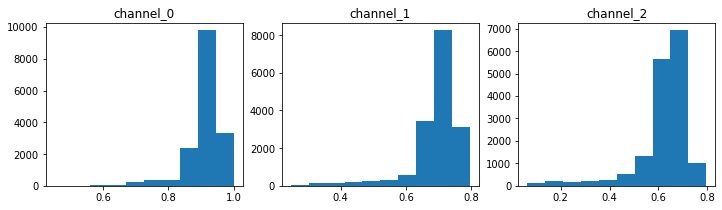

In [ ]:
skin_sample_ch0_np, skin_sample_ch1_np, skin_sample_ch2_np = get_sample_distributions_per_channel(img, mask_inpain, lesion_size)
fig, ax = plt.subplots(1,3, figsize=(12,3))
ax[0].hist(skin_sample_ch0_np); ax[0].set_title('channel_0')
ax[1].hist(skin_sample_ch1_np); ax[1].set_title('channel_1')
ax[2].hist(skin_sample_ch2_np); ax[2].set_title('channel_2');

In [ ]:
# if local
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda':
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor
# if cloud
# dtype = torch.cuda.FloatTensor
PLOT = True
torch.cuda.empty_cache()
skin_sample_ch0 = torch.tensor(np.asarray(skin_sample_ch0_np)).type(dtype)
skin_sample_ch1 = torch.tensor(np.asarray(skin_sample_ch1_np)).type(dtype)
skin_sample_ch2 = torch.tensor(np.asarray(skin_sample_ch2_np)).type(dtype)

In [ ]:
def closure():
    global i
    images_all = []
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
    out = net(net_input)
    
    # ussing KL per channel
    mask_skin = mask_var[0]
    mask_lesion = -mask_skin+1
    out_ch = torch.squeeze(out)
    lesion_only_ch0 =  out_ch[0][torch.where((out_ch[0] * mask_lesion)>0)]
    lesion_only_ch1 =  out_ch[1][torch.where((out_ch[1] * mask_lesion)>0)]
    lesion_only_ch2 =  out_ch[2][torch.where((out_ch[2] * mask_lesion)>0)]
    kl_loss_ch0 = KL(torch.log_softmax(lesion_only_ch0, dim=0), torch.softmax(skin_sample_ch0, dim=0))
    kl_loss_ch1 = KL(torch.log_softmax(lesion_only_ch1, dim=0), torch.softmax(skin_sample_ch1, dim=0))
    kl_loss_ch2 = KL(torch.log_softmax(lesion_only_ch2, dim=0), torch.softmax(skin_sample_ch2, dim=0))
    mse_loss = mse(out * mask_var, img_var * mask_var)
    
    total_loss = mse_loss + kl_loss_ch0 + kl_loss_ch1 + kl_loss_ch2
    total_loss.backward()
        
#     print ('Iteration %05d    Loss %.12f' % (i, total_loss.item()), '\r', end='')
    
    losses = [mse_loss.detach().cpu().numpy(), kl_loss_ch0.detach().cpu().numpy(), kl_loss_ch2.detach().cpu().numpy(), kl_loss_ch2.detach().cpu().numpy()]
    
    if  PLOT:
        out_np = torch_to_np(out)
        image_to_save = out_np
        images_all.append(image_to_save)
        
    i += 1    

    return total_loss, images_all, losses

In [ ]:
pad = 'zero' 
OPT_OVER = 'net'
OPTIMIZER = 'adam'
INPUT = 'noise'
input_depth = channels_input 
num_iter = run_epochs 
param_noise = True
show_every = 500
reg_noise_std = 0.1
LR = 0.01
restart_i = 0
restart = True
params = f'LR={LR}_noise={reg_noise_std}'

In [ ]:
mse_error_all = []
img_np = img
img_mask_np = mask_inpain

In [ ]:
while restart == True:
    start = time.time()
    print(f'training initialization {restart_i} with LR = {LR:.12f}')
    restart_i += 1
    # Loss
    mse = torch.nn.MSELoss().type(dtype)
    KL = nn.KLDivLoss()
    img_var = np_to_torch(img_np).type(dtype)
    mask_var = np_to_torch(img_mask_np).type(dtype)

    net = skip(input_depth, img_np.shape[0], 
            num_channels_down = channels_layers, 
            num_channels_up   = channels_layers[::-1], 
            num_channels_skip = channels_skip, 
            upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3, 
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    net = net.type(dtype)        
    net_input = get_noise2(input_depth, INPUT, img_np.shape[1:], noise_type='n').type(dtype)

    i = 0
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    print(f'noise: {type(noise.detach().cpu().numpy())}, {np.shape(noise.detach().cpu().numpy())}, {np.min(noise.detach().cpu().numpy()), np.mean(noise.detach().cpu().numpy()), np.max(noise.detach().cpu().numpy())}')

    p = get_params(OPT_OVER, net, net_input)
    mse_error, images_generated_all, best_iter, restart, losses = optimize_melanoma_v1(OPTIMIZER, p, closure, LR, num_iter, show_every, path_img_dest, restart, annealing=True, lr_finder_flag=False)
    
    mse_error = [i.detach().cpu().numpy() for i in mse_error]

    if restart_i % 10 == 0: # reduce lr if the network is not learning with the initializations
        LR /= 1.2
    if restart_i == 30: # if the network cannot be trained continue (might not act on for loop!!)
        continue

training initialization 0 with LR = 0.010000000000
using get_noise2
noise: <class 'numpy.ndarray'>, (1, 32, 512, 512), (-0.523038, 2.4274598e-06, 0.5307098)


In [ ]:
save_epochs = [1,2,3,4,5] #[10,20,40,80,100]
images=[]
images_raw=[]
for i in save_epochs:
    img_tmp = images_generated_all[i] * mask_lesion + img *  mask_inpain
    img_tmp = np.swapaxes(img_tmp[0], 0,1); img_tmp = np.swapaxes(img_tmp, 1,2)
    images.append(img_tmp)
    raw_tmp = images_generated_all[i]
    raw_tmp = np.swapaxes(raw_tmp[0], 0,1); raw_tmp = np.swapaxes(raw_tmp, 1,2)
    images_raw.append(raw_tmp)

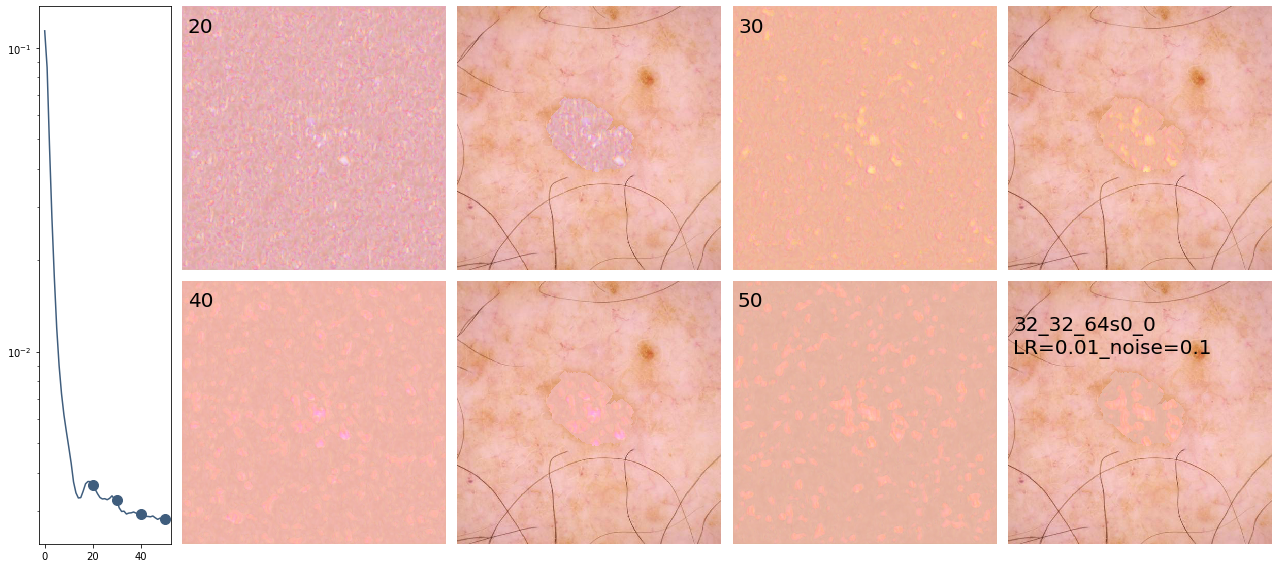

In [ ]:
plot_inpaints_pairs(mse_error, images_raw, images, save_epochs, filename, name_for_fig, params)

In [ ]:
# save individual images
image_denorm = [denormalizePatches(i) for i in images]
image_raw_denorm = [denormalizePatches(i) for i in images_raw]
for (img_to_save, epoch_to_save) in zip(image_denorm, save_epochs):
    im2save = Image.fromarray(img_to_save.astype(np.uint8))
    im2save.save(f'{path_img_dest}final/{filename}_{name}_{epoch_to_save:04d}.png')
for (img_to_save, epoch_to_save) in zip(image_raw_denorm, save_epochs):
    im2save = Image.fromarray(img_to_save.astype(np.uint8))
    im2save.save(f'{path_img_dest}raw/{filename}_{name}_{epoch_to_save:04d}.png')
np.save(f'{path_img_dest}mse/{filename}_{name}.npy', mse_error)

In [ ]:
l_mse = [l[0] for l in losses]
l_kl0 = [l[1] for l in losses]
l_kl1 = [l[2] for l in losses]
l_kl2 = [l[3] for l in losses]

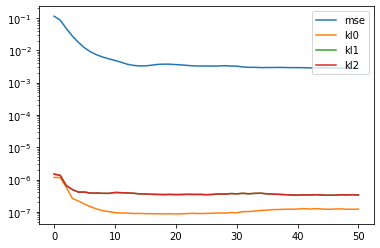

In [ ]:
plt.semilogy(l_mse,label='mse')
plt.semilogy(l_kl0,label='kl0')
plt.semilogy(l_kl1,label='kl1')
plt.semilogy(l_kl2,label='kl2')
plt.legend(loc=1)